In [3]:
import pandas as pd
import os, re 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import seaborn as sns 

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.decomposition import PCA
from numpy.linalg import svd 

#PERMANOVA on SV1/SV2 sample projections of data 
from scipy.spatial import distance_matrix
from skbio.stats import distance as sk_distance 

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

csv_dir = "csv"

In [4]:
#Workspace set-up - data loading, figure directory configuration, final processing of dataset (these steps now 
#done earlier in workflow to subset to cecal contents and remove prevotella species)

DATASET = "rlog"
PARAM_STR = "thr3_prev0.3_cecal_nonprevotella"
ABUNDANCE_CORRECTED_DATA = True

if ABUNDANCE_CORRECTED_DATA:
    figures_dir = "figures/4th_trial/transformed_abundance_corrected/{0}/SVD_{1}".format(PARAM_STR,DATASET)
    bpm_filt_data_path = "formatted_output/4th_trial/bpm_filtered_abundance_corrected/{0}".format(PARAM_STR) 
else: 
    figures_dir = "figures/4th_trial/transformed/{0}/SVD_{1}".format(PARAM_STR,DATASET)
    bpm_filt_data_path = "formatted_output/4th_trial/bpm_filtered/{0}".format(PARAM_STR) 

if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)


bpm_filt_expr_fpath = "{0}/bpm_filt_{1}.csv".format(bpm_filt_data_path,DATASET)
# bpm_filt_expr_fpath = "{0}/mystery.csv".format(bpm_filt_data_path,DATASET)
pht_agg_expr_fpath = "{0}/bpm1_agg_pht_{1}.csv".format(bpm_filt_data_path,DATASET)
condensed_agg_expr_fpath = "{0}/condensed_agg_pht_{1}.csv".format(bpm_filt_data_path,DATASET)

bpm_filt_expr_df = pd.read_csv(bpm_filt_expr_fpath,index_col=0)
pht_agg_expr_df = pd.read_csv(pht_agg_expr_fpath,index_col=0)
condensed_agg_expr_df = pd.read_csv(condensed_agg_expr_fpath,index_col=0)
print("Pre-filtering:")
display(bpm_filt_expr_df)
display(condensed_agg_expr_df)

#Cecal contents only filtering 
cecal_filter = True 
if cecal_filter:
    cecal_bpm_filt_expr_df = bpm_filt_expr_df.loc[:,bpm_filt_expr_df.columns.str.contains("cecal")]
    bpm_filt_expr_df = cecal_bpm_filt_expr_df
    
    cecal_condensed_agg_df = condensed_agg_expr_df.loc[:,condensed_agg_expr_df.columns.str.contains("cecal")]
    condensed_agg_expr_df = cecal_condensed_agg_df

drop_prevotella = True 
if drop_prevotella:
    bpm_filt_expr_df = bpm_filt_expr_df.loc[~bpm_filt_expr_df.index.str.contains(r'NBCBLOMG|NJCFFJJN'),:]
    condensed_agg_expr_df = condensed_agg_expr_df.loc[~condensed_agg_expr_df.index.str.contains(r'Pst|Pco'),:]


feature_center = True
if feature_center:
    bpm_filt_expr_df = bpm_filt_expr_df.subtract(bpm_filt_expr_df.mean(axis=1),axis=0)
    condensed_agg_expr_df = condensed_agg_expr_df.subtract(condensed_agg_expr_df.mean(axis=1),axis=0)
    
assert(np.isclose(bpm_filt_expr_df.mean(axis=1).sum(),0))
assert(np.isclose(condensed_agg_expr_df.mean(axis=1).sum(),0))

#Convert so that samples are rows, features are columns (ie tranpose of previous data format)
data_tranpose = True 
if data_tranpose:
    if not bpm_filt_expr_df.index.str.contains("cecal").sum():
        bpm_filt_expr_df = bpm_filt_expr_df.transpose()
    if not condensed_agg_expr_df.index.str.contains("cecal").sum():
        condensed_agg_expr_df = condensed_agg_expr_df.transpose()
print("Post Filtering/Transpose")
display(bpm_filt_expr_df)
display(condensed_agg_expr_df)
        
        
# print("==BPM=1 Transcripts STD==")        
# display(bpm_filt_expr_df.std(axis=0))
# print("==BPM=1 Phenotypes STD==")        
# display(condensed_agg_expr_df.std(axis=0))

Pre-filtering:


,Pup_1.cecal_contents_53_1C_Pup_1,Pup_2.cecal_contents_53_1C_Pup_2,Pup_3.cecal_contents_53_1C_Pup_3,Pup_4.cecal_contents_53_1C_Pup_4,Pup_5.cecal_contents_53_1C_Pup_5,Pup_6.cecal_contents_53_1C_Pup_6,Pup_7.cecal_contents_53_1C_Pup_7,Pup_8.cecal_contents_53_1C_Pup_8,Pup_1.cecal_contents_54_2B_Pup_1,Pup_2.cecal_contents_54_2B_Pup_2,Pup_3.cecal_contents_54_2B_Pup_3,Pup_4.cecal_contents_54_2B_Pup_4,Pup_5.cecal_contents_54_2B_Pup_5,Pup_6.cecal_contents_54_2B_Pup_6,Pup_7.cecal_contents_54_2B_Pup_7
ANCJAENF_00282,5.172585,3.623032,5.722102,5.574228,5.171693,7.373374,5.144882,4.589921,2.768483,6.131097,3.022222,-0.514100,1.842641,2.429891,3.221199
ANCJAENF_00439,5.397592,4.936961,5.672522,6.107579,5.362107,5.471028,5.481767,5.222900,3.971361,3.481751,2.632350,-0.410602,3.441050,4.800849,4.271900
ANCJAENF_00597,3.739016,2.212646,4.127799,4.452684,3.688393,3.353601,3.792290,3.215569,2.484380,3.672133,1.509298,-1.210111,1.782048,2.108535,2.556539
ANCJAENF_00282,5.172585,3.623032,5.722102,5.574228,5.171693,7.373374,5.144882,4.589921,2.768483,6.131097,3.022222,-0.514100,1.842641,2.429891,3.221199
ANCJAENF_00670,3.515555,3.576098,3.488167,3.384245,3.127852,2.489984,3.232491,4.502919,0.909784,-0.834797,-1.064124,-1.384890,4.833825,2.972843,2.972955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_01949,4.675940,4.593412,5.204295,5.394798,4.236254,4.252203,4.377372,4.950463,5.832872,3.310817,4.602328,4.309601,5.218352,4.551057,5.110742
LDOIJNDB_00521,9.082485,9.821382,9.981349,11.149127,9.682464,10.302770,9.816742,9.703767,10.652929,7.137806,8.230911,8.040021,8.433983,9.875311,9.630565
LDOIJNDB_00521,9.082485,9.821382,9.981349,11.149127,9.682464,10.302770,9.816742,9.703767,10.652929,7.137806,8.230911,8.040021,8.433983,9.875311,9.630565
LDOIJNDB_01036,2.994066,3.855233,3.754212,4.227274,3.305241,3.473230,3.737898,3.709804,4.409014,0.504275,2.132930,2.591987,3.027408,3.818549,3.517692


,Pup_1.cecal_contents_53_1C_Pup_1,Pup_2.cecal_contents_53_1C_Pup_2,Pup_3.cecal_contents_53_1C_Pup_3,Pup_4.cecal_contents_53_1C_Pup_4,Pup_5.cecal_contents_53_1C_Pup_5,Pup_6.cecal_contents_53_1C_Pup_6,Pup_7.cecal_contents_53_1C_Pup_7,Pup_8.cecal_contents_53_1C_Pup_8,Pup_1.cecal_contents_54_2B_Pup_1,Pup_2.cecal_contents_54_2B_Pup_2,Pup_3.cecal_contents_54_2B_Pup_3,Pup_4.cecal_contents_54_2B_Pup_4,Pup_5.cecal_contents_54_2B_Pup_5,Pup_6.cecal_contents_54_2B_Pup_6,Pup_7.cecal_contents_54_2B_Pup_7
Bbr_Glc,4.769731,3.590880,5.174141,5.378163,4.740731,5.399334,4.806313,4.342797,3.074741,4.428327,2.387957,-0.711604,2.355246,3.113092,3.349879
Bbr_Fru,4.344070,3.599565,4.605135,4.479236,4.149772,4.931679,4.188686,4.546420,1.839133,2.648150,0.979049,-0.949495,3.338233,2.701367,3.097077
Bbr_NANA,7.243421,6.632372,7.489605,8.220504,7.467323,8.436747,8.647338,3.803432,3.839599,1.587824,3.779890,0.975647,2.084861,5.930307,6.399256
Bbr_Fuc,7.082770,6.206758,7.182126,8.112594,7.377599,8.151242,7.281576,6.894612,7.281332,7.485495,7.574256,1.787939,2.801610,8.033843,6.733042
Bbr_Mal,6.260736,5.087053,6.352623,7.004504,6.165448,6.614188,6.373830,7.146494,4.331111,2.446331,6.022466,0.698907,2.011313,5.646592,6.453017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Spa_Acetate,5.716164,5.297216,6.203789,5.216262,5.176151,3.803963,5.784328,6.224661,6.106942,4.065372,4.369074,5.230855,5.738891,4.849267,5.105182
Spa_Formate,6.310241,6.626347,7.237646,6.636055,6.259128,5.427400,6.690705,7.282281,7.569995,5.230455,5.819105,6.320404,6.679235,7.112421,6.539628
Spa_L-Lactate,4.675940,4.593412,5.204295,5.394798,4.236254,4.252203,4.377372,4.950463,5.832872,3.310817,4.602328,4.309601,5.218352,4.551057,5.110742
Spa_Ethanol,7.053012,7.832665,7.905636,8.841842,7.556723,8.026256,7.790461,7.705779,8.571624,4.926629,6.198251,6.224010,6.631791,7.856390,7.592941


Post Filtering/Transpose


,ANCJAENF_00282,ANCJAENF_00439,ANCJAENF_00597,ANCJAENF_00282,ANCJAENF_00670,ANCJAENF_01803,ANCJAENF_01805,ANCJAENF_01808,ANCJAENF_01809,ANCJAENF_01810,...,LDOIJNDB_01767,LDOIJNDB_00635,LDOIJNDB_02060,LDOIJNDB_01022,LDOIJNDB_01273,LDOIJNDB_01949,LDOIJNDB_00521,LDOIJNDB_00521,LDOIJNDB_01036,LDOIJNDB_00003
Pup_1.cecal_contents_53_1C_Pup_1,1.087702,1.008185,0.973361,1.087702,1.134027,-0.143778,1.754487,1.755295,1.892229,2.165000,...,0.191050,-0.044995,0.958907,-0.482104,0.070447,-0.032094,-0.353622,-0.353622,-0.276522,-0.356797
Pup_2.cecal_contents_53_1C_Pup_2,-0.461851,0.547554,-0.553008,-0.461851,1.194571,-0.515480,1.044344,1.441093,1.392376,1.540920,...,-0.812170,-0.043027,0.119043,0.214692,0.005863,-0.114622,0.385274,0.385274,0.584645,0.240281
Pup_3.cecal_contents_53_1C_Pup_3,1.637219,1.283114,1.362144,1.637219,1.106640,0.890221,1.910668,2.125038,1.945083,2.242774,...,1.025258,0.685897,1.203266,0.495892,0.947260,0.496262,0.545241,0.545241,0.483624,1.025802
Pup_4.cecal_contents_53_1C_Pup_4,1.489344,1.718172,1.687029,1.489344,1.002718,1.141740,2.518664,3.086290,2.676352,3.095965,...,-1.319252,0.262539,-0.348431,0.469027,-0.229057,0.686764,1.713019,1.713019,0.956686,1.162142
Pup_5.cecal_contents_53_1C_Pup_5,1.086810,0.972700,0.922739,1.086810,0.746325,0.165959,1.902022,2.265009,2.030245,2.337196,...,-0.075857,-0.144498,-0.021616,-0.358515,-0.155368,-0.471780,0.246357,0.246357,0.034653,-0.244041
Pup_6.cecal_contents_53_1C_Pup_6,3.288491,1.081620,0.587946,3.288491,0.108457,1.371701,2.681678,3.277535,2.892290,3.158206,...,-0.785319,-0.763052,-2.147438,-0.122504,-2.054836,-0.455831,0.866662,0.866662,0.202643,0.236660
Pup_7.cecal_contents_53_1C_Pup_7,1.059999,1.092359,1.026636,1.059999,0.850963,0.222729,3.257037,3.569440,3.305981,3.617777,...,-0.397848,0.419112,0.631129,0.078075,0.271196,-0.330661,0.380634,0.380634,0.467311,0.465138
Pup_8.cecal_contents_53_1C_Pup_8,0.505037,0.833493,0.449914,0.505037,2.121392,0.277314,-1.555428,-1.578588,-1.948918,-2.285130,...,0.429555,0.894054,1.036852,0.640382,0.892041,0.242429,0.267660,0.267660,0.439217,0.749156
Pup_1.cecal_contents_54_2B_Pup_1,-1.316400,-0.418047,-0.281275,-1.316400,-1.471743,0.792315,-1.248832,-2.463927,-2.214518,-1.714602,...,1.061229,0.676259,1.019209,1.205217,0.902633,1.124839,1.216821,1.216821,1.138426,0.614080
Pup_2.cecal_contents_54_2B_Pup_2,2.046214,-0.907657,0.906478,2.046214,-3.216324,-1.791921,-4.368267,-4.242253,-4.168271,-4.254106,...,-0.848025,-1.120608,-1.267062,-1.706490,-0.864739,-1.397217,-2.298302,-2.298302,-2.766313,-2.048447


,Bbr_Glc,Bbr_Fru,Bbr_NANA,Bbr_Fuc,Bbr_Mal,Bbr_Scr,Bbr_Lnb,Bbr_All,Bbr_Mel,Bbr_Raf,...,Spa_Glu,Spa_Gln,Spa_Asp,Spa_B3,Spa_B9,Spa_Acetate,Spa_Formate,Spa_L-Lactate,Spa_Ethanol,Spa_CA_d
Pup_1.cecal_contents_53_1C_Pup_1,1.023082,1.110865,1.740879,0.416984,1.019762,-0.017612,0.859055,0.289430,0.765925,0.847548,...,0.301044,0.102624,-0.505727,-0.393162,0.191050,0.456956,-0.205828,-0.032094,-0.327922,-0.356797
Pup_2.cecal_contents_53_1C_Pup_2,-0.155769,0.366360,1.129830,-0.459028,-0.153922,0.483135,-0.999617,1.324453,1.404481,2.496832,...,0.157021,-0.240911,0.043908,-0.121880,-0.812170,0.038008,0.110277,-0.114622,0.451731,0.240281
Pup_3.cecal_contents_53_1C_Pup_3,1.427492,1.371929,1.987063,0.516339,1.111649,0.559727,1.033546,1.296328,0.674248,1.623119,...,1.115259,0.285458,0.671420,0.962231,1.025258,0.944581,0.721576,0.496262,0.524702,1.025802
Pup_4.cecal_contents_53_1C_Pup_4,1.631515,1.246031,2.717962,1.446808,1.763530,3.484489,1.065169,0.859256,1.228221,2.170875,...,0.782655,0.600763,0.461978,-1.192999,-1.319252,-0.042946,0.119985,0.686764,1.460908,1.162142
Pup_5.cecal_contents_53_1C_Pup_5,0.994083,0.916567,1.964782,0.711813,0.924474,2.233254,0.494562,-0.343517,1.355171,1.601434,...,0.485470,-0.468898,-0.253690,-0.181258,-0.075857,-0.083057,-0.256941,-0.471780,0.175789,-0.244041
Pup_6.cecal_contents_53_1C_Pup_6,1.652686,1.698474,2.934205,1.485456,1.373214,0.544011,0.686387,3.702495,-0.560710,1.028737,...,-0.409187,-0.519939,-0.294460,-0.662329,-0.785319,-1.455245,-1.088670,-0.455831,0.645322,0.236660
Pup_7.cecal_contents_53_1C_Pup_7,1.059665,0.955481,3.144796,0.615790,1.132855,0.101456,0.517747,0.212003,-0.992126,-0.005289,...,0.867407,-0.172142,0.161417,0.457739,-0.397848,0.525120,0.174636,-0.330661,0.409527,0.465138
Pup_8.cecal_contents_53_1C_Pup_8,0.596148,1.313215,-1.699110,0.228826,1.905520,0.676851,1.039661,0.782901,2.542085,3.080075,...,0.803366,0.567660,0.808588,0.638087,0.429555,0.965453,0.766212,0.242429,0.324845,0.749156
Pup_1.cecal_contents_54_2B_Pup_1,-0.671907,-1.394072,-1.662943,0.615545,-0.909863,-0.190422,0.704451,0.791561,1.746343,1.210206,...,1.080243,1.337946,0.778582,1.342133,1.061229,0.847734,1.053925,1.124839,1.190689,0.614080
Pup_2.cecal_contents_54_2B_Pup_2,0.681678,-0.585055,-3.914718,0.819709,-2.794643,-4.118803,-0.906977,-3.933986,-1.608164,-3.965133,...,-2.996684,-2.054077,-1.175486,-0.908372,-0.848025,-1.193835,-1.285614,-1.397217,-2.454305,-2.048447


In [5]:
# Sanity check for locus inclusion 
# display(bpm_filt_expr_df["HIAFFLEM_01096"])

select_phts = ["Rob_Xyl","Rob_Ara","Rob_Gln","Rob_Acetate","Mmu_Ara","Mmu_Glu","Mmu_Leu"]
select_phts_df = condensed_agg_expr_df[select_phts]

display(select_phts_df.iloc[:8,:].mean())
display(select_phts_df.iloc[8:,:].mean())
# display(condensed_agg_expr_df["Rob_Leu"])


Rob_Xyl        3.023737
Rob_Ara        2.744227
Rob_Gln        3.060783
Rob_Acetate    3.100138
Mmu_Ara        2.855926
Mmu_Glu        2.030525
Mmu_Leu        2.535541
dtype: float64

Rob_Xyl       -3.455699
Rob_Ara       -3.136259
Rob_Gln       -3.498038
Rob_Acetate   -3.543015
Mmu_Ara       -3.263915
Mmu_Glu       -2.320600
Mmu_Leu       -2.897761
dtype: float64

From np.linalag.svd:
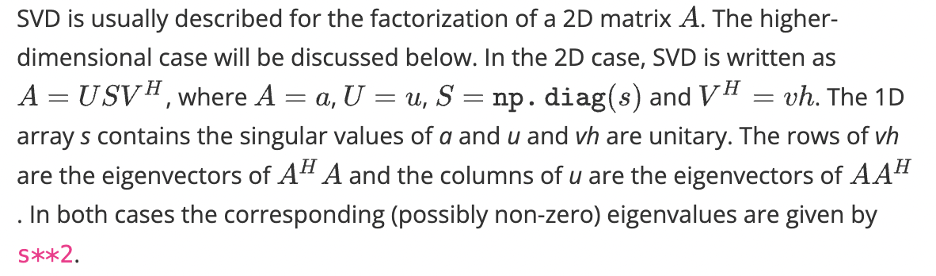

In [6]:
def sv_projections(feature_df,u,s,vh,pc_indices=[0,1],axis=0):
    """Return projections of feature_df onto singular vectors specified by axis 
        feature_df: samples (index) x features (columns)
        u: Matrix of left singular vectors (columns) - n_samples x n_samples
        s: singular values (vector) 
        vh: Matrix of right singular vectors (columns) - n_features x n_features
        pc_indices: list-like of indicies for which singular vectors to generate projections on  
        axis: 0 or 1, for generating sample projections or feature projections respectively 
    """
    #Generate PCs, a len(pc_indices) x {n_samples or n_features} ndarray representing the PCs specified 
    #by pc_indices and axis
    if axis == 0: #sample projections 
        SVs = vh[pc_indices,:]# n_PCs x n_features 
        data = feature_df.values.transpose() #n_features x n_samples
        assert(SVs.shape[1] == data.shape[0])
    elif axis == 1: #feature projections
        SVs = u[:,pc_indices].transpose() #n_PCs x n_samples
        data = feature_df.values #n_samples x n_features 
        assert(SVs.shape[1] == data.shape[0])
    else: 
        raise ValueError("axis must be 0 (sample projections) or 1 (feature projections)")
    #projections = PCs * data
    projections = np.dot(SVs,data)
    return projections
    
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def sig_str_from_pval(pval):
    if pval < 0.0001: 
        sig_str = "****"
    elif pval < 0.001: 
        sig_str = "***"
    elif pval < 0.01: 
        sig_str = "**"
    elif pval < 0.05: 
        sig_str = "*"
    else:
        sig_str = "ns"
    return sig_str

def standardize_plot_style(ax,xlabel,ylabel,title,legend_labels=[],title_size=16,ax_label_size=14,legend_cols=1,
                          legend_title=""):
    ticklabels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight("bold") for label in ticklabels]
    ax.set_xlabel(xlabel,weight="bold",fontsize=ax_label_size)
    ax.set_ylabel(ylabel,weight="bold",fontsize=ax_label_size)
    
    handles,labels = ax.get_legend_handles_labels()
    if len(legend_labels) > 0:
        ax.legend(handles,legend_labels,loc="best",title=legend_title)
    else:
        ax.legend(handles,labels,loc="best",title=legend_title)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1),ncol=legend_cols)
    ax.set_title(title,weight="bold",fontsize=title_size)

Permanova p-value: 0.000180
Permanova p-value: 0.000190


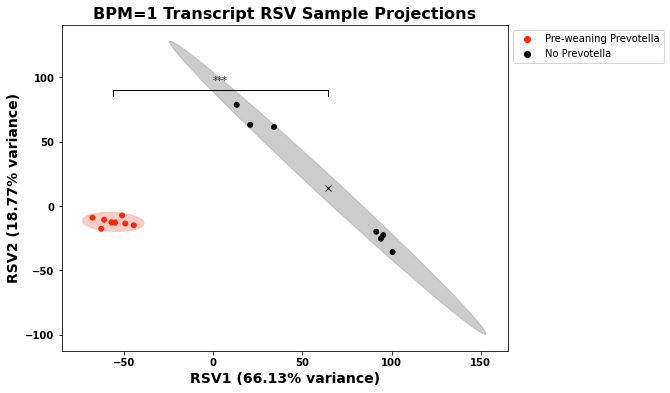

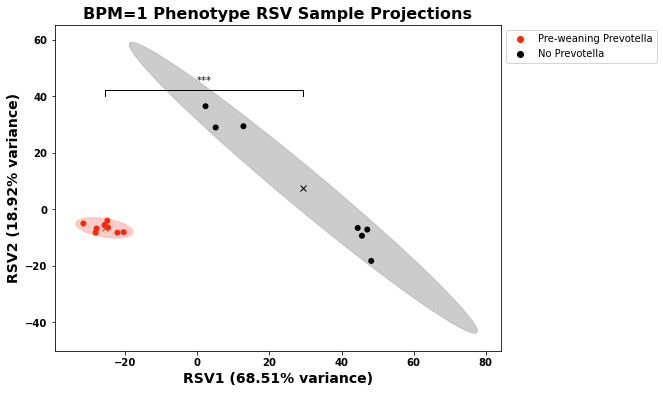

In [7]:
def sample_projections_scatter(expr_df, pc_indices,sample_arm_re=r'[\w_]+\.[\w_]+_([12][ABC])_[\w+]',title_str="",
                              figure_fpath="",arm_labels=["Pre-weaning Prevotella","No Prevotella"]): 
    #Palettes 
    HWDC_points_palette = ["#FF2804","#000000"]
    HWDC_ellipses_palette = ["#FEACA7","#AAAAAA"]
    
    #SVD, explained variance calculations 
    u,s,vh = svd(expr_df)
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    
    #Sample projections
    pc_indices = [0,1]
    sample_projections = sv_projections(expr_df,u,s,vh,pc_indices=pc_indices)
    sample_proj_df = pd.DataFrame(data=sample_projections.T,columns=["RSV1","RSV2"])
    sample_proj_df.loc[:,"Arm"] = expr_df.index.str.extract(sample_arm_re)
    
    v1 = sample_projections.T #M vectors in K dimensions = n_samples x n_PCs
    #permanova requires a skbio.stats.distance.DistanceMatrix object, must convert output  
    sp_dm = sk_distance.DistanceMatrix(distance_matrix(v1,v1,p=2))

    skpa = sk_distance.permanova(distance_matrix=sp_dm,grouping=sample_proj_df["Arm"],permutations=100000)
    skpa_p = skpa["p-value"]
    sig_str = sig_str_from_pval(skpa_p)
    print("Permanova p-value: {:.6f}".format(skpa_p))
    #Scatter plot of sampel projections using 
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    point_palette=HWDC_points_palette
    ellipses_palette = HWDC_ellipses_palette
    sns.scatterplot(data=sample_proj_df,x="RSV1",y="RSV2",hue="Arm",palette=point_palette,zorder=1,linewidth=0)
    
    #Get sample projections subsetted by arm (1C vs 2B), as well as cluster centers for arm
    sample_proj_1C = sample_proj_df.loc[sample_proj_df["Arm"] == "1C",:]
    center_1C_x, center_1C_y = np.mean(sample_proj_1C["RSV1"]),np.mean(sample_proj_1C["RSV2"])
    sample_proj_2B  = sample_proj_df.loc[sample_proj_df["Arm"] == "2B",:]
    center_2B_x, center_2B_y = np.mean(sample_proj_2B["RSV1"]),np.mean(sample_proj_2B["RSV2"])
    #Cluster center markers 
    ax.plot(center_1C_x,center_1C_y,c=point_palette[0],marker='x')
    ax.plot(center_2B_x,center_2B_y,c=point_palette[1],marker='x')
    #Confidence ellipses around each cluster - TODO: adjust n_std to correspond to 95% confidence in 2D (1D equiv of .975)
    ellipse1_c, ellipse2_c = ellipses_palette
    confidence_ellipse(x=sample_proj_1C["RSV1"],y=sample_proj_1C["RSV2"],ax=ax,n_std=2.25,
                       edgecolor=ellipse1_c,facecolor=ellipse1_c,alpha=0.6,zorder=0)
    confidence_ellipse(x=sample_proj_2B["RSV1"],y=sample_proj_2B["RSV2"],ax=ax,n_std=2.25,
                       edgecolor=ellipse2_c,facecolor=ellipse2_c,alpha=0.6,zorder=0)
    #Pyplot Formatting - axis and tick labels, title
    xlabel = "RSV{0} ({1}% variance)".format(pc_indices[0]+1,"%.2f" % (expl_variance[pc_indices[0]]*100))
    ylabel = "RSV{0} ({1}% variance)".format(pc_indices[1]+1,"%.2f" % (expl_variance[pc_indices[1]]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_labels=arm_labels)
    #Significance bracket: x1, x2 = cluster centers (x); y2 = bar y position, y1 = bracket extent 
    x1, x2 = center_1C_x, center_2B_x
    ymin, ymax = ax.get_ylim()
    y2 = ymax - (ymax-ymin)*.2
    y1 = y2-(ymax-ymin)*.02
    plt.text((x1+x2)*.5, y2+(ymax-ymin)*.015, sig_str, ha='center', va='bottom', color='k')
    plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    if figure_fpath:
        plt.savefig(figure_fpath, dpi=300, facecolor='w',bbox_inches="tight",format="pdf")

pc_indices = [0,1]
title_str = "BPM=1 Transcript RSV Sample Projections"
figure_fpath = "{0}/bpm1_transcripts_SVD.pdf".format(figures_dir)
sample_projections_scatter(bpm_filt_expr_df,pc_indices,title_str=title_str,figure_fpath=figure_fpath)


pc_indices = [0,1]
title_str = "BPM=1 Phenotype RSV Sample Projections"
figure_fpath = "{0}/bpm1_condensed_pht_SVD.pdf".format(figures_dir)
sample_projections_scatter(condensed_agg_expr_df,pc_indices,title_str=title_str,figure_fpath=figure_fpath)
# sample_projections_scatter(filt_condensed_agg,pc_indices,title_str=title_str,figure_fpath=figure_fpath)

,RSV1,RSV2,Arm
0,-27.938058,-6.873725,1C
1,-22.148664,-8.340265,1C
2,-31.578760,-5.101472,1C
3,-25.734572,-5.638172,1C
4,-24.766067,-6.514496,1C
5,-20.425328,-8.169932,1C
6,-28.204096,-8.317895,1C
7,-24.928714,-4.068615,1C
8,5.098902,28.905167,2B
9,47.139987,-7.236757,2B


<AxesSubplot:xlabel='RPC1', ylabel='RPC2'>

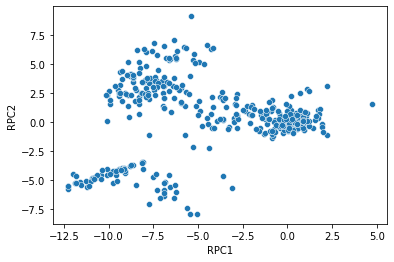

In [8]:
#TEST CELL# Comparing SVD feature projections and sklearn.PCA 
u,s,vh = svd(condensed_agg_expr_df)
eigenvalues = s**2/(len(s)-1)
expl_variance = eigenvalues / np.sum(eigenvalues)

sample_arm_re = r'[\w_]+\.[\w_]+_([12][ABC])_[\w+]'
sample_projections = sv_projections(condensed_agg_expr_df,u,s,vh,pc_indices=pc_indices)
sample_proj_df = pd.DataFrame(data=sample_projections.T,columns=["RSV1","RSV2"])
sample_proj_df.loc[:,"Arm"] = condensed_agg_expr_df.index.str.extract(sample_arm_re)

display(sample_proj_df)

pca = PCA(n_components=2)
pca.fit(condensed_agg_expr_df)
PCA_df = pd.DataFrame(pca.transform(condensed_agg_expr_df),columns=["PC1","PC2"])

R_PCs = np.dot(np.diag(s[pc_indices]),vh[pc_indices,:]).T
R_PCs = np.dot(vh[pc_indices,:].T,np.diag(s[pc_indices]))
# print(R_PCs)
R_PC_df = pd.DataFrame(R_PCs,columns=["RPC1","RPC2"])
sns.scatterplot(data=R_PC_df,x="RPC1",y="RPC2")

# pca_feat = PCA(n_components=2)
# pca_feat.fit(condensed_agg_expr_df.transpose())
# transpose_PCA = pd.DataFrame(data=pca_feat.transform(condensed_agg_expr_df.transpose()),columns=["T.PC1","T.PC2"])
# display(transpose_PCA)
# sns.scatterplot(data=transpose_PCA,x="T.PC1",y="T.PC2")


In [9]:
#Load mcseed_df for strain and phenotype annotations of feature projections 
formatted_dir = "formatted_input"
mcseed_path = "{0}/19isolates_mcseed_pathwaycomplete.csv".format(formatted_dir)

mcseed_df = pd.read_csv(mcseed_path)
mcseed_df.set_index("Locus tag",inplace=True)
mcseed_df_og = mcseed_df.copy()
# mcseed_list_phts = mcseed_df.copy()
for col in ["Functional category","Functional pathway", "Phenotype"]:
#     mcseed_list_phts.loc[:,col] = mcseed_list_phts.loc[:,col].str.split(";")
    mcseed_df.loc[:,col] = mcseed_df.loc[:,col].str.split(";")
    # display(mcseed_df)
# display(mcseed_list_phts)
mcseed_df = mcseed_df_og
display(mcseed_df)
strains = mcseed_df["Isolate name"].unique()

#STRAIN_TAGS maps full strain names to abbreviations 
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
STRAIN_TAGS = dict(zip(strains,STRAIN_ABBREVS))
SHORT_ABBREVS = [abbrev[:3] for abbrev in STRAIN_ABBREVS]
STRAIN_ABBREV_TO_FULL = dict(zip(SHORT_ABBREVS, strains))



,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype
Locus tag,,,,,,
ANCJAENF_00011,Bifidobacterium breve Bgsng463_m5_93,MalE,"Maltose/maltodextrin ABC transporter, substrat...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00013,Bifidobacterium breve Bgsng463_m5_93,MalF,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00014,Bifidobacterium breve Bgsng463_m5_93,MalG,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00052,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac
ANCJAENF_00063,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac
...,...,...,...,...,...,...
LDOIJNDB_02225,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_c,"PTS system, trehalose-specific IIC component (...",Carbohydrate utilization,trehalose utilization,Tre
LDOIJNDB_02226,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_b,"PTS system, trehalose-specific IIB component (...",Carbohydrate utilization,trehalose utilization,Tre
LDOIJNDB_02245,Streptococcus pasteriuanus Bang_SAM2_39_S1,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac


In [10]:
# display(bpm_filt_expr_df) #Fix me - for filtering out high information content features from rest 
# display(condensed_agg_expr_df)
# filt_condensed_agg = condensed_agg_expr_df.loc[:,~condensed_agg_expr_df.columns.isin(bpm_filt_expr_df.columns)]
# display(filt_condensed_agg)

,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
ANCJAENF_00282,-4.710133,-1.496080,Bifidobacterium breve Bgsng463_m5_93,FruA_bif,"PTS system, fructose-specific IIABC (EC 2.7.1....",Carbohydrate utilization,fructose utilization,Fru,Bbr
ANCJAENF_00282,-4.710133,-1.496080,Bifidobacterium breve Bgsng463_m5_93,PtsG_bif,"PTS system, glucose-specific IIABC (EC 2.7.1.69)",Carbohydrate utilization,glucose utilization,Glc,Bbr
ANCJAENF_00439,-5.207901,1.106182,Bifidobacterium breve Bgsng463_m5_93,GlcK,Glucokinase (EC 2.7.1.2),Carbohydrate utilization,glucose utilization,Glc,Bbr
ANCJAENF_00597,-3.676761,0.090479,Bifidobacterium breve Bgsng463_m5_93,PpgK,Polyphosphate glucokinase (EC 2.7.1.63),Carbohydrate utilization,glucose utilization,Glc,Bbr
ANCJAENF_00670,-4.974284,1.062995,Bifidobacterium breve Bgsng463_m5_93,Frk_ScrK; ScrK,Fructokinase (EC 2.7.1.4),Carbohydrate utilization,fructose utilization; sucrose utilization; fru...,Fru; Scr; FOS; Mtl,Bbr
...,...,...,...,...,...,...,...,...,...
LDOIJNDB_01949,-0.443952,0.947801,Streptococcus pasteriuanus Bang_SAM2_39_S1,LdhA-L,L-lactate dehydrogenase (EC 1.1.1.27),Fermentation products,L-lactate production,L-Lactate,Spa
LDOIJNDB_00521,-2.964663,1.657854,Streptococcus pasteriuanus Bang_SAM2_39_S1,AADH,Acetaldehyde dehydrogenase (EC 1.2.1.10),Fermentation products,ethanol production,Ethanol,Spa
LDOIJNDB_00521,-2.964663,1.657854,Streptococcus pasteriuanus Bang_SAM2_39_S1,ADH,Alcohol dehydrogenase (EC 1.1.1.1),Fermentation products,ethanol production,Ethanol,Spa
LDOIJNDB_01036,-2.312487,1.593714,Streptococcus pasteriuanus Bang_SAM2_39_S1,ADH,Alcohol dehydrogenase (EC 1.1.1.1),Fermentation products,ethanol production,Ethanol,Spa


,LSV1,LSV2,Strain abbreviation,Phenotype
Bbr_Glc,-4.467796,-0.138352,Bbr,Glc
Bbr_Fru,-4.779619,-0.320005,Bbr,Fru
Bbr_NANA,-8.319657,0.661299,Bbr,NANA
Bbr_Fuc,-3.744808,2.200623,Bbr,Fuc
Bbr_Mal,-5.734382,1.374366,Bbr,Mal
...,...,...,...,...
Spa_Acetate,-1.049161,0.247510,Spa,Acetate
Spa_Formate,-0.886271,1.172782,Spa,Formate
Spa_L-Lactate,-0.523118,0.909985,Spa,L-Lactate
Spa_Ethanol,-2.864282,1.430448,Spa,Ethanol


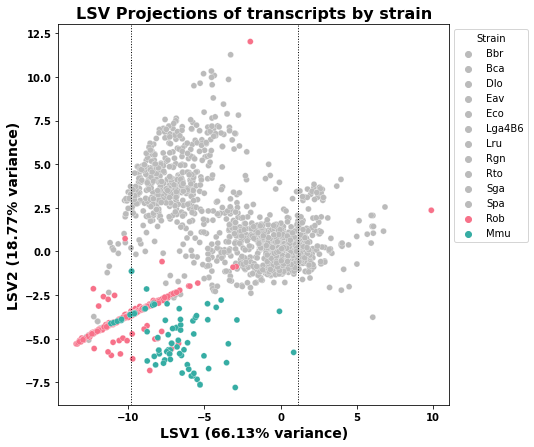

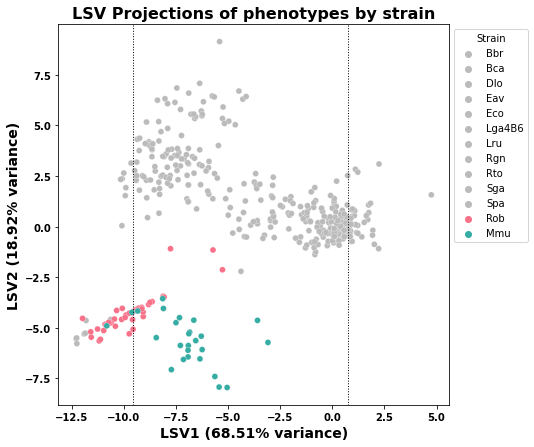

In [11]:
# def LSV_percentile_lines()
ROB_MMU_REST_PALETTE = dict(zip(STRAIN_ABBREVS,["#BBBBBB"]*len(STRAIN_ABBREVS)))
ROB_MMU_REST_PALETTE["Rob"] = "#EB8032"
ROB_MMU_REST_PALETTE["Mmu"] = "#639DF4"

# {"Rob":,"Mmu":,""}

def LSV_percentiles(fp_df,LSV_col="LSV1",percentile=10):
    n_features = len(fp_df)
    n_percentile_features = int(np.ceil(n_features * percentile/100))
    LSV_sorted = fp_df.sort_values(LSV_col)
    bottom, top = LSV_sorted.iloc[0:n_percentile_features,:],LSV_sorted.iloc[-n_percentile_features:]
    return bottom, top 

def LSV_percentile_vlines(fp_df,ax,LSV_col="LSV1",percentile=10):
    bottom_lsv, top_lsv = LSV_percentiles(fp_df,LSV_col,percentile)
    bottom_cutoff = bottom_lsv.iloc[-1][LSV_col]
    top_cutoff = top_lsv.iloc[0][LSV_col]
    ymin,ymax = ax.get_ylim()
    ax.vlines([bottom_cutoff,top_cutoff],ymin,ymax,color='black',linewidth=1,linestyles='dotted')
    ax.set_ylim(ymin,ymax)

def LSV_feature_projections(expr_df,pc_indices,mcseed_df,feature_type="transcript",title_str="",fig_fpath="",
                           partition_strains=[],partition_palette={}):
    if feature_type=="transcript":
        u,s,vh = svd(expr_df)
    elif feature_type=="phenotype":
        u,s,vh = svd(expr_df,full_matrices=True)
    else:
        raise ValueError("feature_type must be 'transcript' or 'phenotype'")
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    feature_projections = sv_projections(expr_df,u,s,vh,axis=1,pc_indices=pc_indices)
    PC_columns = ["LSV{0}".format(pc_idx+1) for pc_idx in pc_indices]
    fp_df = pd.DataFrame(data=feature_projections.T,columns=PC_columns)
    fp_df.set_index(expr_df.columns,inplace=True)
    
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    
    #mcseed annotation of fp_df 
    if feature_type=="transcript":
        mcseed_filt = mcseed_df.loc[mcseed_df.index.isin(fp_df.index),:]
        fp_mcseed_join = fp_df.merge(right=mcseed_filt,left_index=True,right_index=True,sort=True)
        fp_df_mcseed = fp_mcseed_join.loc[fp_df.index,:].drop_duplicates(subset=fp_mcseed_join.columns[:5])
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.loc[:,"Isolate name"].map(STRAIN_TAGS)
    elif feature_type=="phenotype":
        fp_df_mcseed = fp_df.copy()
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.index.str.extract("(\w+?)\_[\w\-]+",expand=False)
        fp_df_mcseed.loc[:,"Phenotype"] = fp_df_mcseed.index.str.extract("\w+?\_([\w\-]+)",expand=False) #comaptible with string format phenotypes
#         fp_df_mcseed.loc[:,"Phenotype"] = fp_df_mcseed.index.str.extract("\w+?\_([\w\-]+)",expand=False)
    display(fp_df_mcseed)
    #Solo phenotype LSV Plot
    strain_palette = sns.color_palette("husl", len(fp_df_mcseed["Strain abbreviation"].unique())) #husl
    strain_palette = ROB_MMU_REST_PALETTE
    
    if len(partition_strains) > 0:
        if len(partition_palette) >0 :
            strain_palette = partition_palette
        else: 
            partition_palette = sns.color_palette("husl",len(partition_strains))
            rest_palette = dict(zip(list(fp_df_mcseed["Strain abbreviation"].unique()),
                                    ["#BBBBBB"]*len(fp_df_mcseed["Strain abbreviation"].unique())))
            strain_palette = rest_palette
            for i,strain in enumerate(partition_strains):
                strain_palette[strain] = partition_palette[i]
        #Use Z-order to prioritize partition
        fp_partition = fp_df_mcseed.loc[fp_df_mcseed["Strain abbreviation"].isin(partition_strains)]
        fp_rest = fp_df_mcseed.loc[~fp_df_mcseed["Strain abbreviation"].isin(partition_strains)]
        sns.scatterplot(data=fp_rest,x="LSV1",y="LSV2",ax=ax,
                    palette=strain_palette,hue="Strain abbreviation",linewidth=0.25,zorder=0)
        sns.scatterplot(data=fp_partition,x="LSV1",y="LSV2",ax=ax,
                    palette=strain_palette,hue="Strain abbreviation",linewidth=0.25,zorder=1)
    else:
        strain_palette = sns.color_palette("husl", len(fp_df_mcseed["Strain abbreviation"].unique()))
        sns.scatterplot(data=fp_df_mcseed,x="LSV1",y="LSV2",ax=ax,
                    palette=strain_palette,hue="Strain abbreviation",linewidth=0.25)
    xlabel = "{0} ({1}% variance)".format(PC_columns[0],"%.2f" % (expl_variance[0]*100))
    ylabel = "{0} ({1}% variance)".format(PC_columns[1],"%.2f" % (expl_variance[1]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_cols=1,legend_title="Strain")
    
#     bottom_percentile, top_percentile = LSV_percentiles(fp_df_mcseed,LSV_col="LSV{0}".format(pc_indices[0]+1))
    LSV_percentile_vlines(fp_df_mcseed,ax,LSV_col="LSV{0}".format(pc_indices[0]+1))
    if fig_fpath: 
        plt.savefig(fig_fpath,dpi=300,bbox_inches="tight",facecolor="white",format="pdf")
        
partition_strains = ["Rob","Mmu"]
# partition_strains = []
ROB_MMU_REST_PALETTE = dict(zip(STRAIN_ABBREVS,["#BBBBBB"]*len(STRAIN_ABBREVS)))
ROB_MMU_REST_PALETTE["Rob"] = "#EB8032"
ROB_MMU_REST_PALETTE["Mmu"] = "#639DF4"
        
title_str = "LSV Projections of transcripts by strain"
fig_fpath = "{0}/LSV_transcript_projections_by_strain.pdf".format(figures_dir)
LSV_feature_projections(bpm_filt_expr_df,pc_indices,mcseed_df,feature_type="transcript",
                       title_str=title_str,fig_fpath=fig_fpath,
                       partition_strains=partition_strains)

title_str = "LSV Projections of phenotypes by strain"
fig_fpath = "{0}/LSV_phenotype_projections_by_strain.pdf".format(figures_dir)
LSV_feature_projections(condensed_agg_expr_df,pc_indices,mcseed_df,feature_type="phenotype",
                       title_str=title_str,fig_fpath=fig_fpath,
                       partition_strains=partition_strains)
        


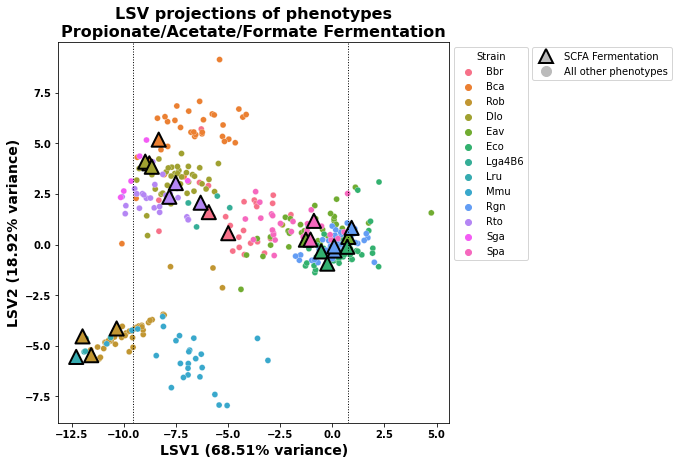

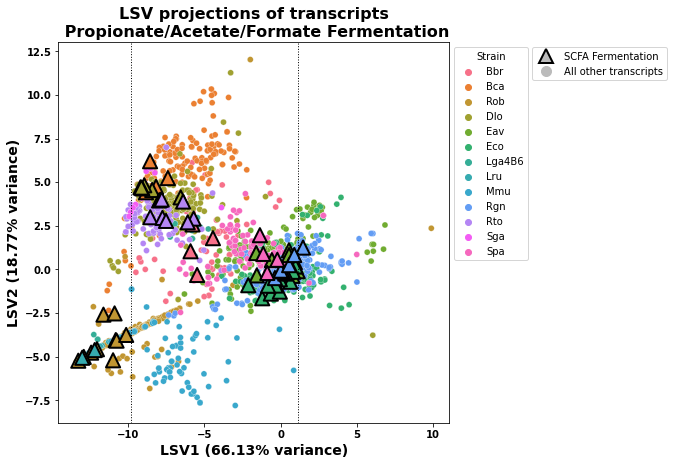

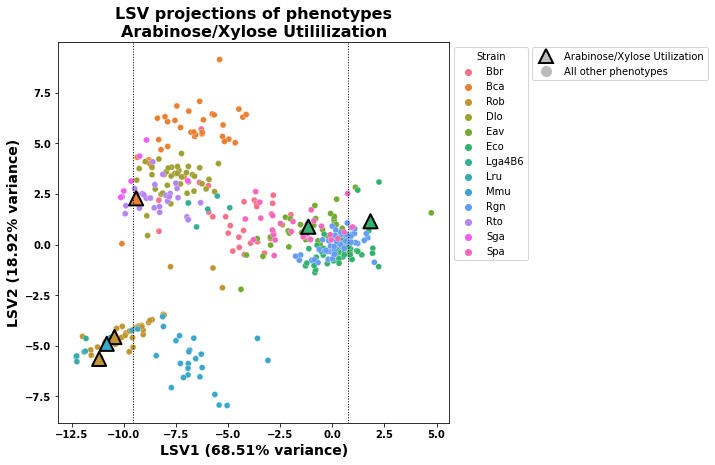

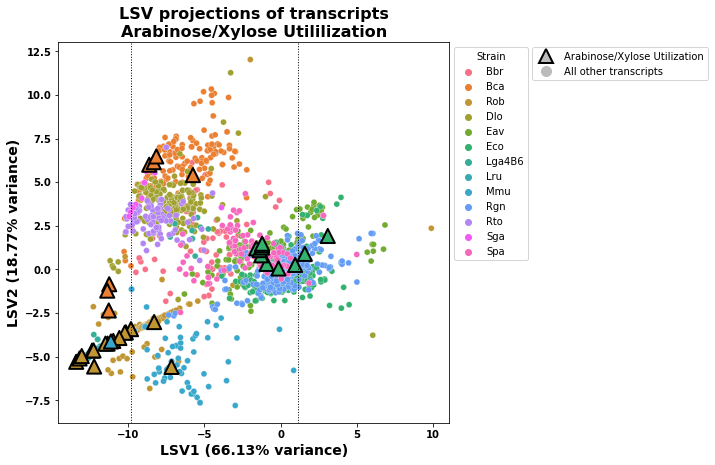

In [12]:


def LSV_feature_projections_partition(expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                                      feature_type="transcript",title_str="",partition_label="",fig_fpath=""):
    #SVD 
    if feature_type=="transcript":
        u,s,vh = svd(expr_df)
    elif feature_type=="phenotype":
        u,s,vh = svd(expr_df,full_matrices=True)
    else:
        raise ValueError("feature_type must be 'transcript' or 'phenotype'")
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    #Feature projections of expr_df 
    feature_projections = sv_projections(expr_df,u,s,vh,axis=1,pc_indices=pc_indices)
    PC_columns = ["LSV{0}".format(pc_idx+1) for pc_idx in pc_indices]
    fp_df = pd.DataFrame(data=feature_projections.T,columns=PC_columns)
    fp_df.set_index(expr_df.columns,inplace=True)
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    #mcseed annotation of fp_df 
    if feature_type=="transcript":
        mcseed_filt = mcseed_df.loc[mcseed_df.index.isin(fp_df.index),:]
        fp_mcseed_join = fp_df.merge(right=mcseed_filt,left_index=True,right_index=True,sort=True)
        fp_df_mcseed = fp_mcseed_join.loc[fp_df.index,:].drop_duplicates(subset=fp_mcseed_join.columns[:5])
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.loc[:,"Isolate name"].map(STRAIN_TAGS)
    elif feature_type=="phenotype":
        fp_df_mcseed = fp_df.copy()
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.index.str.extract("(\w+?)\_[\w\-]+",expand=False)
        fp_df_mcseed.loc[:,"Phenotype"] = fp_df_mcseed.index.str.extract("\w+?\_([\w\-]+)",expand=False)
    
    #Deprecated - string version of phenotype lists from mcseed_df  
    #convert list of partition col match values into re, use str.match (for transcripts which may have more than one
    #associated phenotype)
    if(type(fp_df_mcseed["Phenotype"].iloc[0])) == list:
        #TODO: fill me 
        pass
    elif(type(fp_df_mcseed["Phenotype"].iloc[0])) == str:
        match_pattern = '|'.join(partition_values)
        partition_match = fp_df_mcseed.loc[fp_df_mcseed[partition_col].str.match(match_pattern)]
        partition_rest = fp_df_mcseed.loc[~fp_df_mcseed[partition_col].str.match(match_pattern)]
    
#     print(partition_match[partition_col].unique())
    #strain palette in dict format, keyed by abbreviation so partition data points have correct colors 
    strain_palette = sns.color_palette("husl", len(fp_df_mcseed["Strain abbreviation"].unique()))
    strain_palette = dict(zip(fp_df_mcseed["Strain abbreviation"].unique(),strain_palette))
    #Scatter plot for rest, then matched (triangle, black border, large markers)
    sns.scatterplot(data=partition_rest,x="LSV1",y="LSV2",ax=ax,
                palette=strain_palette,hue="Strain abbreviation",linewidth=0.25)
    strain_handles,strain_labels = ax.get_legend_handles_labels() #Pass as legend labels later to prevent duplicate entries
    sns.scatterplot(data=partition_match,x="LSV1",y="LSV2",ax=ax,
                palette=strain_palette,hue="Strain abbreviation",marker="^",edgecolor="#000000",
                    linewidth=2,s=200)
    #Pyplot formatting
    xlabel = "{0} ({1}% variance)".format(PC_columns[0],"%.2f" % (expl_variance[0]*100))
    ylabel = "{0} ({1}% variance)".format(PC_columns[1],"%.2f" % (expl_variance[1]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_cols=1,legend_title="Strain",
                           legend_labels=strain_labels)
    #Partition Legend
    plt.gca().add_artist(ax.get_legend())
    rest_marker = matplotlib.lines.Line2D([],[],color="#BBBBBB",marker="o",linestyle='None',markersize=10,
                                          label="All other {0}s".format(feature_type.lower()))
    if not partition_label:
        partition_label = ", ".join(partition_values)
    partition_marker = matplotlib.lines.Line2D([],[],color="#BBBBBB",marker="^",linestyle='None',
                                               markeredgecolor='black',markeredgewidth=2,
                                               markersize=14,label=partition_label)
    LSV_percentile_vlines(fp_df_mcseed,ax,LSV_col="LSV{0}".format(pc_indices[0]+1))
    ax.legend(handles=[partition_marker,rest_marker])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.2,1))
    #Save figure if fig_path provided 
    if fig_fpath: 
        plt.savefig(fig_fpath,dpi=300,bbox_inches="tight",facecolor="white",format="pdf")
    return fig, fp_df_mcseed
#Transcript LSV projections with fermentation partition   
fermentation_phts = ["Propionate","Acetate","Formate"]
# fermentation_phts = ["Propionate"]
fermentation_lactate_phts = ["Propionate","Acetate","Ethanol","L-Lactate","D-Lactate","Lac_ut"]
ara_xyl_phts = ["Ara","Xyl"]


title_str = "LSV projections of phenotypes\nPropionate/Acetate/Formate Fermentation"
fig_fpath = "{0}/pht_LSV_fermentation.pdf".format(figures_dir)
partition_col = "Phenotype"
partition_values = fermentation_phts
partition_label = "SCFA Fermentation"
fig, fp_pht_mcseed = LSV_feature_projections_partition(condensed_agg_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                        feature_type="phenotype",
                       title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)

#Transcript LSV projections with fermentation partition
title_str = "LSV projections of transcripts\n Propionate/Acetate/Formate Fermentation"
fig_fpath = "{0}/transcript_LSV_fermentation.pdf".format(figures_dir)
partition_col = "Phenotype"
partition_values = fermentation_phts
partition_label = "SCFA Fermentation"
fig, fp_tr_mcseed = LSV_feature_projections_partition(bpm_filt_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                        feature_type="transcript",
                       title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)

title_str = "LSV projections of phenotypes\nArabinose/Xylose Utililization"
fig_fpath = "{0}/pht_LSV_AraXyl.pdf".format(figures_dir)
partition_col = "Phenotype"
partition_values = ara_xyl_phts
partition_label = "Arabinose/Xylose Utilization"
fig, fp_pht_mcseed = LSV_feature_projections_partition(condensed_agg_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                        feature_type="phenotype",
                       title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)

#Transcript LSV projections with fermentation partition
title_str = "LSV projections of transcripts\nArabinose/Xylose Utililization"
fig_fpath = "{0}/transcript_LSV_AraXyl.pdf".format(figures_dir)
partition_col = "Phenotype"
partition_values = ara_xyl_phts
partition_label = "Arabinose/Xylose Utilization"
fig, fp_tr_mcseed = LSV_feature_projections_partition(bpm_filt_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                        feature_type="transcript",
                       title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)

In [13]:
##Overall strongest LSV +/- projections: 10th percentile##
print("Top and bottom percentiles of LSV1")
bottom_pht,top_pht = LSV_percentiles(fp_pht_mcseed,LSV_col="LSV1",percentile=10)
bottom_tr,top_tr = LSV_percentiles(fp_tr_mcseed,LSV_col="LSV1",percentile=10)
display(bottom_pht)
display(top_pht)

# print("Top and bottom percentiles of LSV2")
# bottom_pht,top_pht = LSV_percentiles(fp_pht_mcseed,LSV_col="LSV2",percentile=10)
# bottom_tr,top_tr = LSV_percentiles(fp_tr_mcseed,LSV_col="LSV2",percentile=10)
# display(bottom_pht)
# display(top_pht)

Top and bottom percentiles of LSV1


,LSV1,LSV2,Strain abbreviation,Phenotype
Lru_Formate,-12.290409,-5.548619,Lru,Formate
Lru_Ethanol,-12.270049,-5.500872,Lru,Ethanol
Lru_L-Lactate,-12.258156,-5.781441,Lru,L-Lactate
Rob_Acetate,-11.986714,-4.533607,Rob,Acetate
Lru_Man,-11.907739,-5.299445,Lru,Man
Lru_Bgl,-11.850452,-5.265229,Lru,Bgl
Lga4B6_MurNac,-11.819573,-4.638274,Lga4B6,MurNac
Rob_Gln,-11.593663,-5.200810,Rob,Gln
Rob_Propionate,-11.569700,-5.462764,Rob,Propionate
Rob_Chb,-11.265400,-5.060757,Rob,Chb


,LSV1,LSV2,Strain abbreviation,Phenotype
Eco_Lys_d,0.771526,-0.109055,Eco,Lys_d
Eco_Bgl,0.772446,-0.135402,Eco,Bgl
Eco_His,0.792929,-0.274385,Eco,His
Eco_Gly,0.804795,-0.398559,Eco,Gly
Eco_B9,0.818863,-0.004979,Eco,B9
Rgn_Glu,0.837848,0.102600,Rgn,Glu
Eco_Ethanol,0.838480,-0.358993,Eco,Ethanol
Eco_MurNac,0.839018,0.192763,Eco,MurNac
Eco_BA_t,0.854912,-0.495040,Eco,BA_t
Eco_All,0.857007,-0.251613,Eco,All


In [14]:
#Ara and Xyl pht, all strains 
display(fp_pht_mcseed[fp_pht_mcseed["Phenotype"].isin(ara_xyl_phts)])
#R. obeum transcripts with Ara/Xyl annotation 
AX_match_pattern = '|'.join(["Ara","Xyl"])
Rob_top3_match = '|'.join(["Xyl","Acetate","Gln"])
Mmu_top3_match = '|'.join(["Ara","Leu","Glu"])

# display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rob")
#                      & (fp_tr_mcseed["Phenotype"].str.contains(AX_match_pattern))].sort_values("LSV1"))
# display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Mmu")
#                      & (fp_tr_mcseed["Phenotype"].str.contains(AX_match_pattern))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rob")
                     & (fp_tr_mcseed["Phenotype"].str.contains(Rob_top3_match))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Mmu")
                     & (fp_tr_mcseed["Phenotype"].str.contains(Mmu_top3_match))].sort_values("LSV1"))

,LSV1,LSV2,Strain abbreviation,Phenotype
Bca_Ara,-9.415568,2.285444,Bca,Ara
Rob_Xyl,-11.189454,-5.646348,Rob,Xyl
Rob_Ara,-10.455466,-4.566749,Rob,Ara
Eco_Xyl,1.829190,1.150984,Eco,Xyl
Eco_Ara,-1.154710,0.881685,Eco,Ara
Mmu_Ara,-10.826388,-4.901381,Mmu,Ara


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
HIAFFLEM_01301,-13.419554,-5.299224,Blautia obeum Bg7063_SSTS2015,XylH,"Xylose ABC transporter, permease protein XylH",Carbohydrate utilization,xylose utilization,Xyl,Rob
HIAFFLEM_02424,-13.199026,-5.107201,Blautia obeum Bg7063_SSTS2015,XylA2,predicted xylose isomerase,Carbohydrate utilization,xylose utilization; xylooligosaccharides utili...,Xyl; XOS,Rob
HIAFFLEM_00270,-12.923091,-5.018418,Blautia obeum Bg7063_SSTS2015,AckA,Acetate kinase (EC 2.7.2.1),Fermentation products,acetate production,Acetate,Rob
HIAFFLEM_02425,-12.375814,-4.658553,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_01302,-12.241148,-5.569868,Blautia obeum Bg7063_SSTS2015,XylG,D-xylose transport ATP-binding protein XylG,Carbohydrate utilization,xylose utilization,Xyl,Rob
HIAFFLEM_00723,-11.931127,-4.479060,Blautia obeum Bg7063_SSTS2015,GlnN,"Glutamine synthetase type III, GlnN (EC 6.3.1.2)",Amino acids,glutamine biosynthesis,Gln,Rob
HIAFFLEM_00271,-11.631535,-2.595208,Blautia obeum Bg7063_SSTS2015,Pta,Phosphate acetyltransferase (EC 2.3.1.8),Fermentation products,acetate production,Acetate,Rob
HIAFFLEM_01096,-11.359802,-4.257967,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_01075,-10.986609,-4.103279,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_01303,-7.161681,-5.591920,Blautia obeum Bg7063_SSTS2015,XylF,"Xylose ABC transporter, periplasmic xylose-bin...",Carbohydrate utilization,xylose utilization,Xyl,Rob


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
ONMCJBAG_00857,-11.141073,-4.132589,Mitsuokella multacida DSM_20544,AraA,L-arabinose isomerase (EC 5.3.1.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Mmu
ONMCJBAG_01954,-10.953579,-4.085666,Mitsuokella multacida DSM_20544,IlvE,Branched-chain amino acid aminotransferase (EC...,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_01769,-9.888500,-3.634736,Mitsuokella multacida DSM_20544,LeuB,3-isopropylmalate dehydrogenase (EC 1.1.1.85),Amino acids,leucine biosynthesis,Leu,Mmu
ONMCJBAG_00607,-8.932119,-3.292311,Mitsuokella multacida DSM_20544,IlvM,Acetolactate synthase small subunit (EC 2.2.1.6),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_00882,-8.757734,-6.282229,Mitsuokella multacida DSM_20544,GltD,Glutamate synthase [NADPH] small chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Mmu
ONMCJBAG_00736,-6.715952,-5.096786,Mitsuokella multacida DSM_20544,LivB,"Branched-chain amino acid ABC transporter, ami...",Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_00608,-6.573713,-3.901015,Mitsuokella multacida DSM_20544,IlvG,Acetolactate synthase large subunit (EC 2.2.1.6),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_00446,-5.589679,-3.793227,Mitsuokella multacida DSM_20544,Gdh1,NADP-specific glutamate dehydrogenase (EC 1.4....,Amino acids,glutamate biosynthesis,Glu,Mmu
ONMCJBAG_01765,-5.029925,-5.990096,Mitsuokella multacida DSM_20544,IlvM,Acetolactate synthase small subunit (EC 2.2.1.6),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_01766,-2.976919,-7.804424,Mitsuokella multacida DSM_20544,IlvC; IlvC2,Ketol-acid reductoisomerase (NADP(+)) (EC 1.1....,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu


In [15]:
#TODO: bacteria by bacteria LSV projections 
# Bbr, Bca, Rob, ...  
#Eav, Eco; 

# display(fp_pht_mcseed)
if ABUNDANCE_CORRECTED_DATA:
    lsv_data_path = "formatted_output/4th_trial/lsv_tables/abundance_corrected/{0}".format(PARAM_STR) 
else:
    lsv_data_path = "formatted_output/4th_trial/lsv_tables/uncorrected/{0}".format(PARAM_STR) 
if not os.path.exists(lsv_data_path):
    os.makedirs(lsv_data_path)
# for strain in ["Bbr","Bca","Rob","Eav","Eco","Rgn","Mmu"]:
for strain in fp_pht_mcseed["Strain abbreviation"].unique():
    strain_fp = fp_pht_mcseed.loc[fp_pht_mcseed["Strain abbreviation"]==strain]
    strain_fp = strain_fp.sort_values("LSV1")#sort by LSV1
    display(strain_fp)
    strain_fpath = "{0}/{1}_LSV.csv".format(lsv_data_path,strain)
    strain_fp.to_csv(strain_fpath)
    

,LSV1,LSV2,Strain abbreviation,Phenotype
Bbr_Raf,-8.324225,2.192154,Bbr,Raf
Bbr_NANA,-8.319657,0.661299,Bbr,NANA
Bbr_Met,-6.376152,3.066399,Bbr,Met
Bbr_Mel,-6.289844,5.710786,Bbr,Mel
Bbr_All,-5.945896,2.909512,Bbr,All
Bbr_Acetate,-5.929765,1.603857,Bbr,Acetate
Bbr_Mal,-5.734382,1.374366,Bbr,Mal
Bbr_Thr,-5.119644,1.376780,Bbr,Thr
Bbr_Formate,-4.996427,0.563421,Bbr,Formate
Bbr_Scr,-4.899645,0.939565,Bbr,Scr


,LSV1,LSV2,Strain abbreviation,Phenotype
Bca_Mel,-10.096717,0.045375,Bca,Mel
Bca_Ara,-9.415568,2.285444,Bca,Ara
Bca_Ethanol,-9.360529,4.312636,Bca,Ethanol
Bca_Lac,-8.803920,4.188017,Bca,Lac
Bca_Formate,-8.781775,4.013788,Bca,Formate
Bca_GOS,-8.746789,4.123518,Bca,GOS
Bca_Leu,-8.392879,6.243053,Bca,Leu
Bca_Acetate,-8.332789,5.185317,Bca,Acetate
Bca_Mal,-8.222692,4.688866,Bca,Mal
Bca_Raf,-8.068538,3.458686,Bca,Raf


,LSV1,LSV2,Strain abbreviation,Phenotype
Rob_Acetate,-11.986714,-4.533607,Rob,Acetate
Rob_Gln,-11.593663,-5.200810,Rob,Gln
Rob_Propionate,-11.569700,-5.462764,Rob,Propionate
Rob_Chb,-11.265400,-5.060757,Rob,Chb
Rob_Xyl,-11.189454,-5.646348,Rob,Xyl
Rob_GOS,-11.129378,-5.568436,Rob,GOS
Rob_Aga,-10.969376,-5.134291,Rob,Aga
Rob_Scr,-10.910574,-4.829051,Rob,Scr
Rob_Tyr,-10.865711,-4.827932,Rob,Tyr
Rob_Bgl,-10.794857,-4.872985,Rob,Bgl


,LSV1,LSV2,Strain abbreviation,Phenotype
Dlo_Thr_d,-9.385939,3.185484,Dlo,Thr_d
Dlo_Gln,-9.268792,3.755865,Dlo,Gln
Dlo_Acetate,-8.977440,4.098291,Dlo,Acetate
Dlo_Tre,-8.906368,1.420786,Dlo,Tre
Dlo_NANA,-8.866966,0.443539,Dlo,NANA
Dlo_Formate,-8.664791,3.845638,Dlo,Formate
Dlo_Gal,-8.657732,3.454014,Dlo,Gal
Dlo_Leu,-8.648384,3.799536,Dlo,Leu
Dlo_Lac_ut,-8.499286,2.743636,Dlo,Lac_ut
Dlo_Tyr,-8.322382,4.228131,Dlo,Tyr


,LSV1,LSV2,Strain abbreviation,Phenotype
Eav_All,-4.385074,-2.211473,Eav,All
Eav_bMnOS,-4.120436,-0.516884,Eav,bMnOS
Eav_GalN,-3.605439,0.295725,Eav,GalN
Eav_Bgl,-3.330954,-0.582297,Eav,Bgl
Eav_Ser,-2.971100,0.376044,Eav,Ser
Eav_Thr_d,-2.963793,-0.026515,Eav,Thr_d
Eav_EA_ut,-2.254715,1.350443,Eav,EA_ut
Eav_Fru,-2.123627,0.673810,Eav,Fru
Eav_Ile,-2.088810,-0.114725,Eav,Ile
Eav_Gtl,-2.057740,0.563803,Eav,Gtl


,LSV1,LSV2,Strain abbreviation,Phenotype
Eco_ddGlcA,-1.289310,-1.052790,Eco,ddGlcA
Eco_Pro_d,-1.228383,-0.912324,Eco,Pro_d
Eco_Ara,-1.154710,0.881685,Eco,Ara
Eco_NANA,-1.125827,-0.200792,Eco,NANA
Eco_EA_ut,-0.879990,-1.036574,Eco,EA_ut
...,...,...,...,...
Eco_Xyl,1.829190,1.150984,Eco,Xyl
Eco_B1,1.925205,-0.423563,Eco,B1
Eco_Fru,1.941121,-0.182541,Eco,Fru
Eco_Srl,2.218369,-1.091111,Eco,Srl


,LSV1,LSV2,Strain abbreviation,Phenotype
Lga4B6_MurNac,-11.819573,-4.638274,Lga4B6,MurNac
Lga4B6_Man,-6.911088,2.055951,Lga4B6,Man
Lga4B6_GlcNAc,-6.911088,2.055951,Lga4B6,GlcNAc
Lga4B6_Thr_d,-6.515211,0.872826,Lga4B6,Thr_d
Lga4B6_Asp,-5.980734,1.754210,Lga4B6,Asp
Lga4B6_Bgl,-5.521290,2.397032,Lga4B6,Bgl
Lga4B6_L-Lactate,-4.923375,1.819574,Lga4B6,L-Lactate


,LSV1,LSV2,Strain abbreviation,Phenotype
Lru_Formate,-12.290409,-5.548619,Lru,Formate
Lru_Ethanol,-12.270049,-5.500872,Lru,Ethanol
Lru_L-Lactate,-12.258156,-5.781441,Lru,L-Lactate
Lru_Man,-11.907739,-5.299445,Lru,Man
Lru_Bgl,-11.850452,-5.265229,Lru,Bgl
Lru_B6,-10.640687,-4.587733,Lru,B6


,LSV1,LSV2,Strain abbreviation,Phenotype
Mmu_Ara,-10.826388,-4.901381,Mmu,Ara
Mmu_Leu,-9.618691,-4.234621,Mmu,Leu
Mmu_Q,-9.339001,-4.169705,Mmu,Q
Mmu_Met,-8.450343,-5.485444,Mmu,Met
Mmu_Srl,-8.140243,-3.559283,Mmu,Srl
Mmu_Tyr,-8.105435,-4.045425,Mmu,Tyr
Mmu_Gly,-7.725097,-7.066790,Mmu,Gly
Mmu_Asp,-7.504048,-4.745216,Mmu,Asp
Mmu_B12,-7.334843,-4.499917,Mmu,B12
Mmu_Thr,-7.292674,-5.870867,Mmu,Thr


,LSV1,LSV2,Strain abbreviation,Phenotype
Rgn_Fcs,-1.765321,-0.569897,Rgn,Fcs
Rgn_GOS,-1.585861,-0.772114,Rgn,GOS
Rgn_Mel,-1.524181,-0.510243,Rgn,Mel
Rgn_GalAs,-1.262813,0.443943,Rgn,GalAs
Rgn_GlcNAc,-0.988412,-0.779254,Rgn,GlcNAc
Rgn_Rhi,-0.862726,-0.751183,Rgn,Rhi
Rgn_NANA,-0.689091,-0.889176,Rgn,NANA
Rgn_Rha,-0.635092,-0.239278,Rgn,Rha
Rgn_Lnb,-0.467701,0.240442,Rgn,Lnb
Rgn_Scr,-0.372560,-0.325685,Rgn,Scr


,LSV1,LSV2,Strain abbreviation,Phenotype
Rto_Ile,-10.084866,2.366589,Rto,Ile
Rto_Fru,-9.937873,1.526610,Rto,Fru
Rto_Scr,-9.907325,1.922425,Rto,Scr
Rto_Rha,-9.484426,2.758774,Rto,Rha
Rto_Aga,-9.403358,2.515092,Rto,Aga
Rto_Arg,-9.384416,2.506462,Rto,Arg
Rto_GlcNAc,-9.258461,1.797874,Rto,GlcNAc
Rto_Fuc,-9.109824,2.514990,Rto,Fuc
Rto_Pro,-9.047673,2.457911,Rto,Pro
Rto_Gly,-8.923199,2.289319,Rto,Gly


,LSV1,LSV2,Strain abbreviation,Phenotype
Sga_Scr,-10.157279,2.332484,Sga,Scr
Sga_Fru,-10.007225,2.645410,Sga,Fru
Sga_Aga,-9.659871,3.137432,Sga,Aga
Sga_Ethanol,-9.246492,4.367614,Sga,Ethanol
Sga_FruLys,-8.918600,5.165402,Sga,FruLys
Sga_Mal,-6.940272,3.151184,Sga,Mal


,LSV1,LSV2,Strain abbreviation,Phenotype
Spa_ManNAc,-4.175554,1.263974,Spa,ManNAc
Spa_bMnOS,-3.789568,0.241471,Spa,bMnOS
Spa_Aga,-3.681500,2.615588,Spa,Aga
Spa_GalN,-3.480726,2.094284,Spa,GalN
Spa_Rha,-3.433334,1.307969,Spa,Rha
Spa_Mal,-2.918431,1.513488,Spa,Mal
Spa_Glu,-2.877099,0.720406,Spa,Glu
Spa_Ethanol,-2.864282,1.430448,Spa,Ethanol
Spa_Man,-2.825593,0.566214,Spa,Man
Spa_Bgl,-2.824105,0.486546,Spa,Bgl


In [214]:
# display(fp_pht_mcseed[fp_pht_mcseed["Phenotype"].isin(["Ara","Xyl"])])

,LSV1,LSV2,Strain abbreviation,Phenotype,Functional category
Bbr_Glc,-1.110581,-0.329777,Bbr,Glc,Carbohydrate utilization
Bbr_Fru,-0.925038,-0.758154,Bbr,Fru,Carbohydrate utilization
Bbr_NANA,-2.805257,-0.090054,Bbr,NANA,Carbohydrate utilization
Bbr_Fuc,-0.702139,0.709547,Bbr,Fuc,Carbohydrate utilization
Bbr_Mal,-1.345476,0.443534,Bbr,Mal,Carbohydrate utilization
...,...,...,...,...,...
Spa_Acetate,-0.507529,-0.030060,Spa,Acetate,Fermentation products
Spa_Formate,-0.316746,0.631503,Spa,Formate,Fermentation products
Spa_L-Lactate,0.056741,0.316089,Spa,L-Lactate,Fermentation products
Spa_Ethanol,-0.985609,0.729584,Spa,Ethanol,Fermentation products


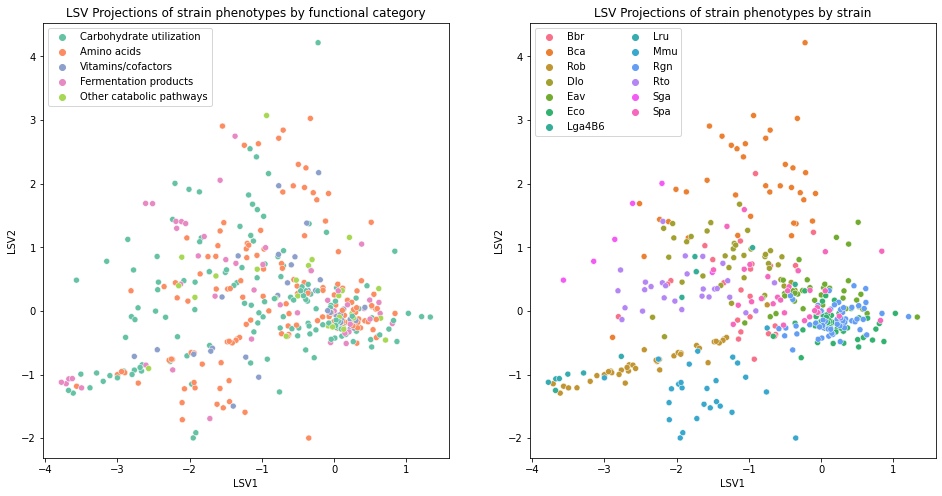

In [133]:
#Mapping pathways back to functional categories 
#Use mcseed_df (without list version phenotypes) for list of phenotype unique values 
pht_fc_dict = {}
for pht_str in mcseed_df["Phenotype"].unique(): #pht_str is a variable length semicolon separated string of different phenotypes
    pht_list = pht_str.split(";") 
    pht_str_rows = mcseed_df.loc[mcseed_df["Phenotype"]==pht_str,:]
    assert(len(pht_str_rows["Functional category"].unique()) == 1)
    fc_cat_str = pht_str_rows["Functional category"].iloc[0]
    fc_cat_list = fc_cat_str.split(";")
    for i,pht in enumerate(pht_list):
        if pht not in pht_fc_dict:
            if len(fc_cat_list) == 1: #If only one functional category for all entries in pht_str, use that category
                pht_fc_dict[pht] = fc_cat_list[0]
            elif len(fc_cat_list) == len(pht_list): #If one-to-one mapping of phenotypes to functional categories, go in order
                pht_fc_dict[pht] = fc_cat_list[i]
            else: #Not one-to-one mapping of phenotypes to functional categories; use some HARD CODING TM  
                print(pht_str)
                print(fc_cat_str)
                raise ValueError("Cannot automatically match phenotypes to functional categories based on prior entries")

fp_pht_mcseed.loc[:,"Functional category"] = fp_pht_mcseed["Phenotype"].map(pht_fc_dict)
display(fp_pht_mcseed)

n_fc_unique = len(fp_pht_mcseed["Functional category"].unique())
# fc_palette = sns.color_palette("husl", n_fc_unique)
fc_palette = sns.color_palette("Set2")[:n_fc_unique]
fig,axes = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = axes
#Strain phenotypes by functional category
strain_palette = sns.color_palette("husl", len(fp_pht_mcseed["Strain abbreviation"].unique()))
sns.scatterplot(data=fp_pht_mcseed,x="LSV1",y="LSV2",ax=ax1,
                palette=fc_palette,hue="Functional category")
handles,labels = ax1.get_legend_handles_labels()
ax1.legend(handles,labels,loc="best")
ax1.set_title("LSV Projections of strain phenotypes by functional category")
#Strain phenotypes by strain
sns.scatterplot(data=fp_pht_mcseed,x="LSV1",y="LSV2",ax=ax2,
                palette=strain_palette,hue="Strain abbreviation")
handles,labels = ax2.get_legend_handles_labels()
ax2.legend(handles,labels,loc="best",ncol=2)
ax2.set_title("LSV Projections of strain phenotypes by strain")
plt.savefig("{0}/feature_projections_SVD.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")

plt.savefig("{0}/phenotypes_functionalcategory_SVD.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")


In [134]:
#SVD Feature Comparison 
u_tr,s_tr,vh_tr = svd(bpm_filt_log_df)
u_pht,s_pht,vh_pht = svd(condensed_agg_log_df,full_matrices=True)

#Explained variance calculated from s -> eigenvalues 
eigenvalues_tr = s_tr**2/(len(s_tr)-1)
expl_variance_tr = eigenvalues_tr / np.sum(eigenvalues_tr)
eigenvalues_pht = s_pht**2/(len(s_pht)-1)
expl_variance_pht = eigenvalues_pht / np.sum(eigenvalues_pht)

n_SV = 2
print("Explained Variance (Transcripts, first {0}): {1}".format(n_SV,expl_variance_tr[:n_SV]))
print("Explained Variance (Phenotype, first {0}): {1}".format(n_SV,expl_variance_pht[:n_SV]))

LSV1_tr = u_tr[:,0]
RSV1_tr = vh_tr[0,:]

print("LSV1 Transcript")
print(LSV1_tr)
print("RSV1 Transcript")
print(RSV1_tr)

LSV1_pht = u_pht[:,0]
RSV1_pht = vh_pht[0,:]

tr_10th, tr_90th = np.percentile(RSV1_tr,[10,90])
print(tr_10th,tr_90th)
pht_10th, pht_90th = np.percentile(RSV1_pht,[10,90])
print(pht_10th,pht_90th)
hist_color = sns.color_palette("Set2")[2]
vline_color = sns.color_palette("Set2")[7]
#Subplots and axes set up, grids, titles, x_labels with PC
fig,axes = plt.subplots(2,1,figsize=(8,10))
ax1,ax2 = axes
for ax in [ax1,ax2]:
    ax.grid(visible=True,color="white")
    ax.set_axisbelow(True)
    ax.set_facecolor("#EBEAF2")
    ax.set_ylabel("Counts")
ax1.set_title("Transcript Projections onto Transcript LSV1")
ax1.set_xlabel("LSV{0} ({1}% variance)".format(pc_indices[0]+1,
                                              "%.2f" % (expl_variance_tr[pc_indices[0]]*100)))
ax2.set_title("Strain Phenotype Projections onto Strain LSV1")
ax2.set_xlabel("LSV{0} ({1}% variance)".format(pc_indices[0]+1,
                                              "%.2f" % (expl_variance_pht[pc_indices[0]]*100)))
#Histogram and vline plotting for histogram 10th and 90th percentiles 
ax1.hist(RSV1_tr.flatten(),bins=25,color=hist_color)
ax1_ylim = ax1.get_ylim()
ax1.vlines([tr_10th,tr_90th],*ax1.get_ylim(),color=vline_color,linewidth=1.5)
ax1.set_ylim(ax1_ylim) #without this line vlines resets ylims for some reason - specific to using hist 
ax2.hist(RSV1_pht.flatten(),bins=25,color=hist_color)
ax2_ylim = ax2.get_ylim()
ax2.vlines([pht_10th,pht_90th],*ax2.get_ylim(),color=vline_color,linewidth=1.5)
ax2.set_ylim(ax2_ylim)

plt.savefig("{0}/LSV1_projection_histogram.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")

NameError: name 'bpm_filt_log_df' is not defined